## Import Libraries and Load Dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from pandas import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.preprocessing import StandardScaler

from scalecast.Forecaster import Forecaster

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


print('_________________All Libraries Have Been Installed.__________________')

C:\Users\The Lion\AppData\Local\Temp\ipykernel_17620\4170561363.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


_________________All Libraries Have Been Installed.__________________


In [6]:
dataset = pd.read_excel('../data/raw/2020Q1Q2Q3Q4-2021Q1.xlsx', sheet_name = None, 
                        parse_dates=['Date'], index_col = 'Date', skipfooter=1)

In [7]:
#check how many sheets are in the file
print('Sheets in dataset: ',len(dataset.keys()))

Sheets in dataset:  8


In [8]:
#Some basic info for every sheet in dataset.
for sheet in range(len(dataset.keys())):
    each_set = dataset[list(dataset.keys())[sheet]]
    print(f'----------Name of dataset is "{list(dataset.keys())[sheet]}"----------')
    print(each_set)
    print(f'Null values in dataset are \n{each_set.isnull().sum()}')
    print(f'Duplicated values in dataset are {each_set.duplicated().sum()}')
    print('\n\n\n')

----------Name of dataset is "Russia - Sberbank Rossii PAO (S"----------
             Price    Open    High     Low    Vol.  Change %
Date                                                        
2021-03-31  291.02  294.00  294.42  290.26  47.00M   -0.0076
2021-03-30  293.25  294.86  295.72  291.50  38.81M   -0.0002
2021-03-29  293.30  289.72  294.09  289.26  43.68M    0.0071
2021-03-26  291.22  288.63  292.75  288.32  56.07M    0.0159
2021-03-25  286.66  286.50  287.03  283.85  35.22M    0.0030
...            ...     ...     ...     ...     ...       ...
2020-01-10  258.19  257.86  259.25  256.88  18.85M    0.0008
2020-01-09  257.99  259.40  261.76  257.01  38.33M   -0.0045
2020-01-08  259.15  253.57  259.15  253.03  40.82M    0.0207
2020-01-06  253.90  254.75  254.84  251.40  22.35M   -0.0043
2020-01-03  255.00  255.99  258.19  253.70  35.85M    0.0010

[311 rows x 6 columns]
Null values in dataset are 
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    

Above done Analysis shows there are no null values or duplicated rows in all 8 sheets.

In [9]:
#checking for different values in column 'Vol.'
for sheet in range(len(dataset.keys())):
    each_set = dataset[list(dataset.keys())[sheet]]
    print(each_set['Vol.'].str[-1].unique())

['M']
['M']
['M' 'K']
['M']
['K' 'M']
['K' 'M']
['M' 'K']
['K' 'M' '-']


'Vol.' column is object data type with with postfix like 'M','K' for million, thousands respectively and '-' for zeros. They will be converted to show thier respective amount in every sheet.

In [10]:
def convert_vol(dataset):
    for sheet in range(len(dataset.keys())):
        each_set = dataset[list(dataset.keys())[sheet]]
        each_set['Vol.'] = each_set['Vol.'].apply(lambda x: float(x.strip('M'))*1000000 if x[-1]=='M'
                                                  else (float(x.strip('K'))*1000 if x[-1]=='K' 
                                                        else(float(x.replace('-','0')) if x[-1]=='-' else x)))
    return dataset

In [11]:
final_dataset = convert_vol(dataset)

In [12]:
data = final_dataset[list(final_dataset.keys())[0]]

There are total 8 sheets in dataset available. I will choose one to perform exploratory data analysis.

In [13]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47000000.0,-0.0076
2021-03-30,293.25,294.86,295.72,291.50,38810000.0,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030


In [14]:
data.describe()

,Price,Open,High,Low,Vol.,Change %
count,311.000000,311.000000,311.000000,311.000000,3.110000e+02,311.000000
mean,234.524019,234.417846,237.314759,231.366141,7.305698e+07,0.000668
std,32.079847,32.058167,32.075624,32.076603,3.805809e+07,0.021931
min,174.270000,175.000000,182.200000,172.150000,8.760000e+06,-0.095700
25%,207.700000,207.215000,209.660000,204.475000,4.767000e+07,-0.010100
50%,229.140000,229.080000,231.950000,226.860000,6.626000e+07,0.000400
75%,264.380000,263.885000,267.255000,261.110000,8.512000e+07,0.012950
max,293.300000,294.860000,296.070000,291.500000,2.630400e+08,0.129000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2021-03-31 to 2020-01-03
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB


In [16]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47000000.0,-0.0076
2021-03-30,293.25,294.86,295.72,291.50,38810000.0,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43680000.0,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56070000.0,0.0159
2021-03-25,286.66,286.50,287.03,283.85,35220000.0,0.0030


### Exploratory Data Analysis

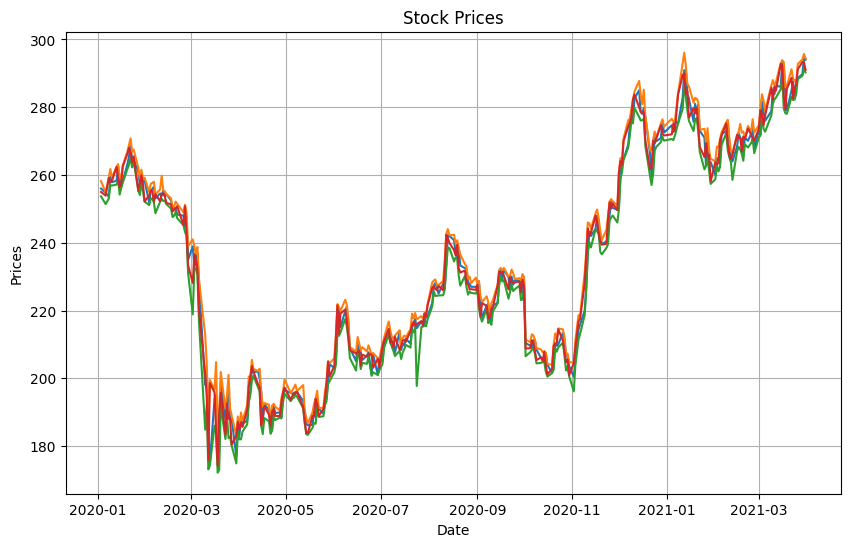

In [17]:
#plot prices
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(data[['Open','High','Low', 'Price']])
plt.title('Stock Prices')
plt.show()

## Analysis
Above plot shows that closing price has always been between high and low prices, and trending upwards in later year, indicating profit.

## Decomposition

I will divide the data into trend, seasonality, and noise to better understand seasonal components and thier impact.
Decompostion requires proper time intervals or frequencies, here I will check for it.

In [18]:
print(f'Frequency of the dataframe: {data.index.freq}')

Frequency of the dataframe: None


In [19]:
data_freq = data.resample('B').mean()
print(data_freq.isna().sum())

Price       14
Open        14
High        14
Low         14
Vol.        14
Change %    14
dtype: int64


In [20]:
data_freq.shape

(324, 6)

In [21]:
data_freq.fillna(method = 'ffill', inplace = True)

seperating 'Price' column as it will be the only one used for further work.

In [22]:
price = data_freq['Price']

<Figure size 640x480 with 0 Axes>

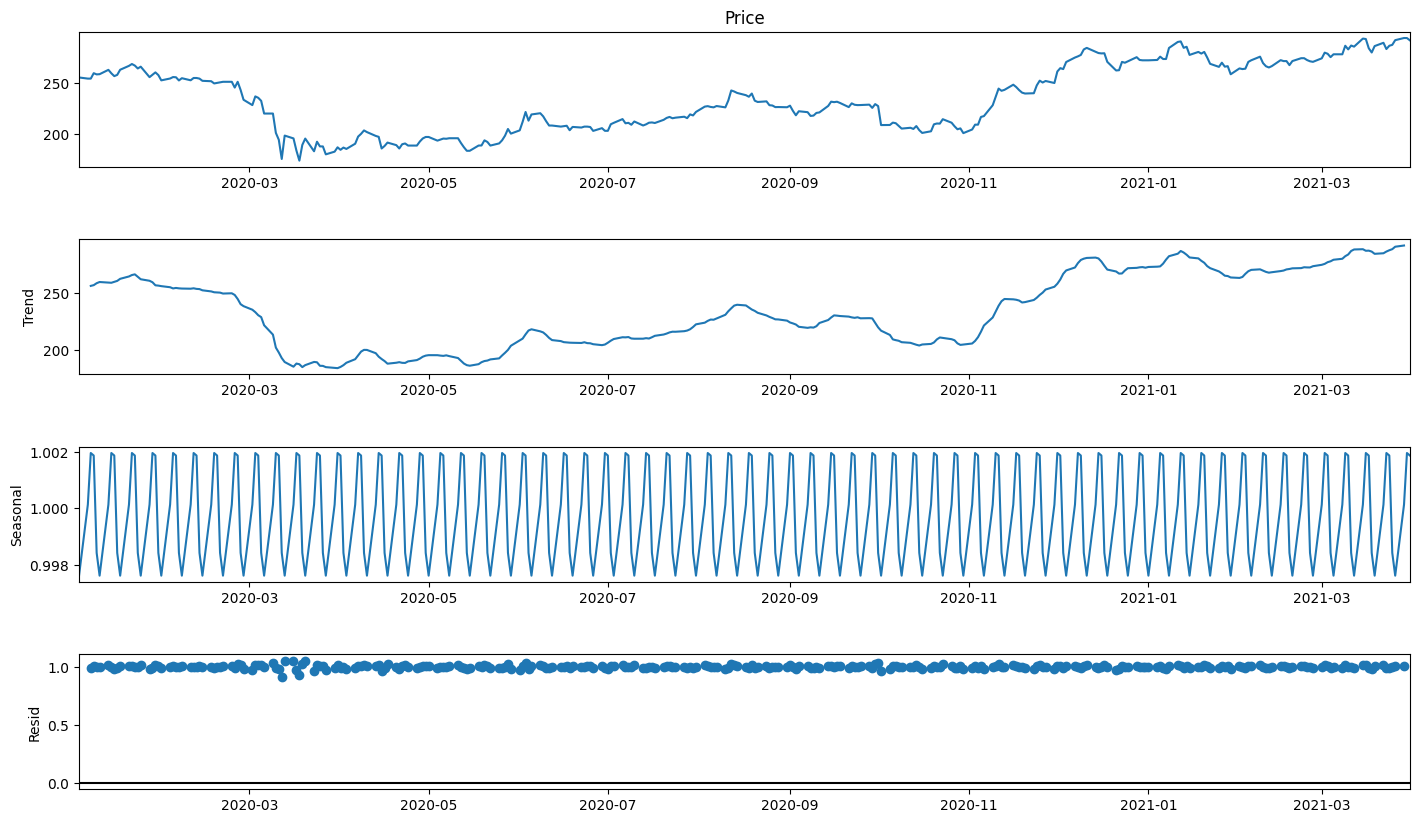

In [23]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(price, model='multiplicative') 
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

This function uses augmented fuller test to check stationarity of the data.

In [24]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.grid(True)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

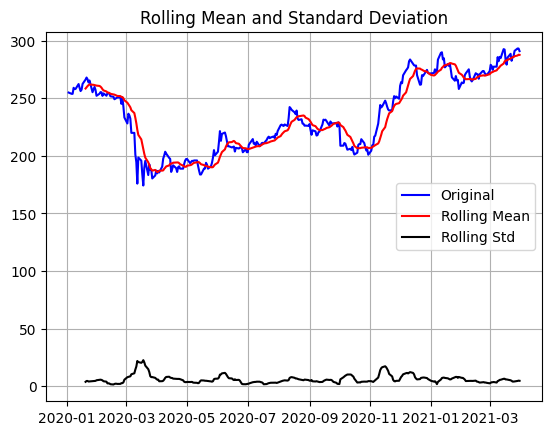

Results of dickey fuller test
Test Statistics                 -1.041861
p-value                          0.737692
No. of lags used                 4.000000
Number of observations used    319.000000
critical value (1%)             -3.451017
critical value (5%)             -2.870643
critical value (10%)            -2.571620
dtype: float64


In [25]:
test_stationarity(price)

For data to be stationary test statictics has to be smaller than critical value (1%). and p-value less than 0.05. As we can see from above table p-vlaue is greater 0.05 and test statistic is also big which means data is non stationary.

I will try differencing with moving average on the data to see the results.

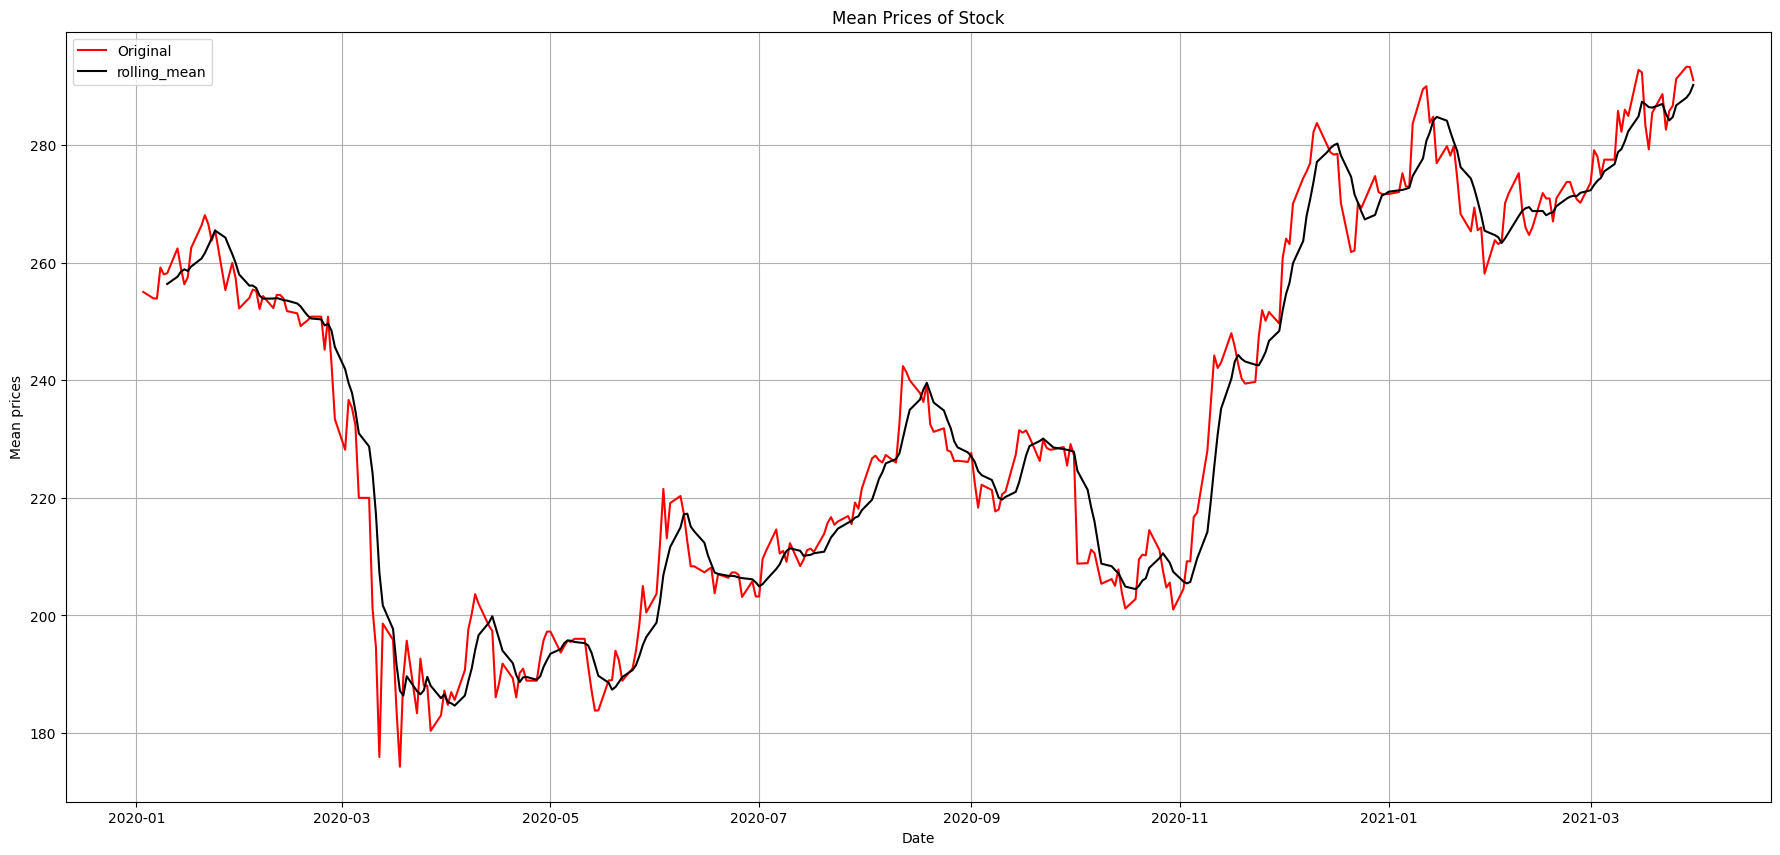

In [26]:
# Moving average method
moving_avg = price.rolling(6).mean()
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(price, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "rolling_mean")
plt.title("Mean Prices of Stock")
plt.xlabel("Date")
plt.ylabel("Mean prices")
plt.legend()
plt.show()

In [27]:
ts_moving_avg_diff = price - moving_avg
ts_moving_avg_diff.dropna(inplace=True)

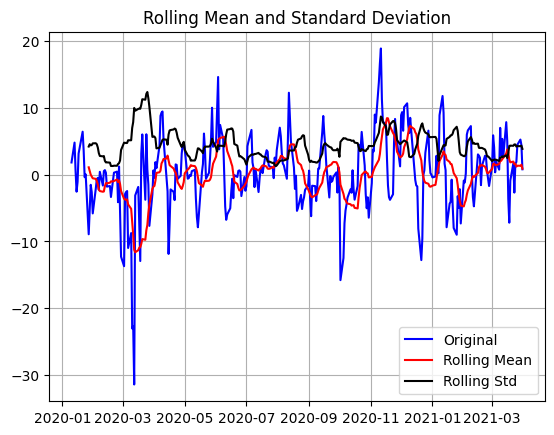

Results of dickey fuller test
Test Statistics                 -4.378900
p-value                          0.000323
No. of lags used                12.000000
Number of observations used    306.000000
critical value (1%)             -3.451902
critical value (5%)             -2.871032
critical value (10%)            -2.571827
dtype: float64


In [28]:
test_stationarity(ts_moving_avg_diff)

Test statistics and p-value show that our dataset is stationary now.

## Train test split

In [29]:
#split data into train and training set
train_data = price[0:(price.index.year==2020).sum()]
test_data = price[(price.index.year==2020).sum():]

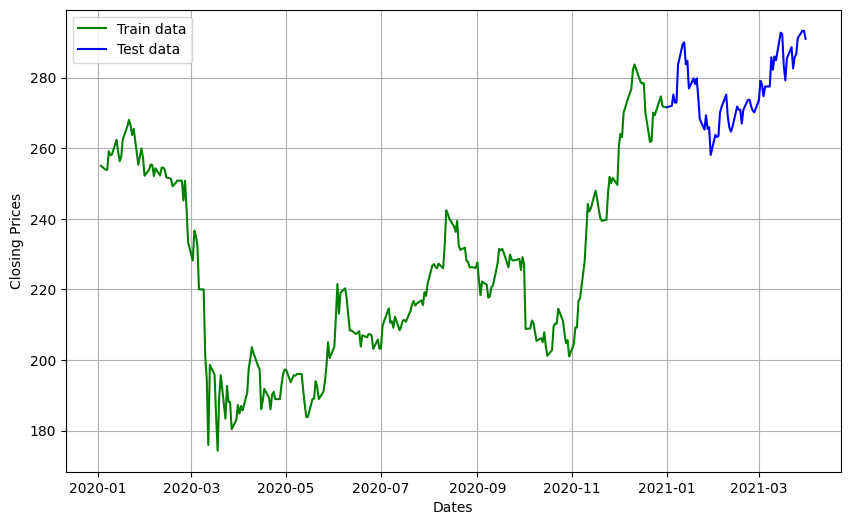

In [30]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2017.531, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1778.746, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1862.703, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1778.984, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1779.137, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1780.891, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1780.610, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.375 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  319
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -887.373
Date:                Sun, 15 Jan 2023   AIC                           1778.746
Time:                        21:48:10   BIC                           1786.277
Sample:                

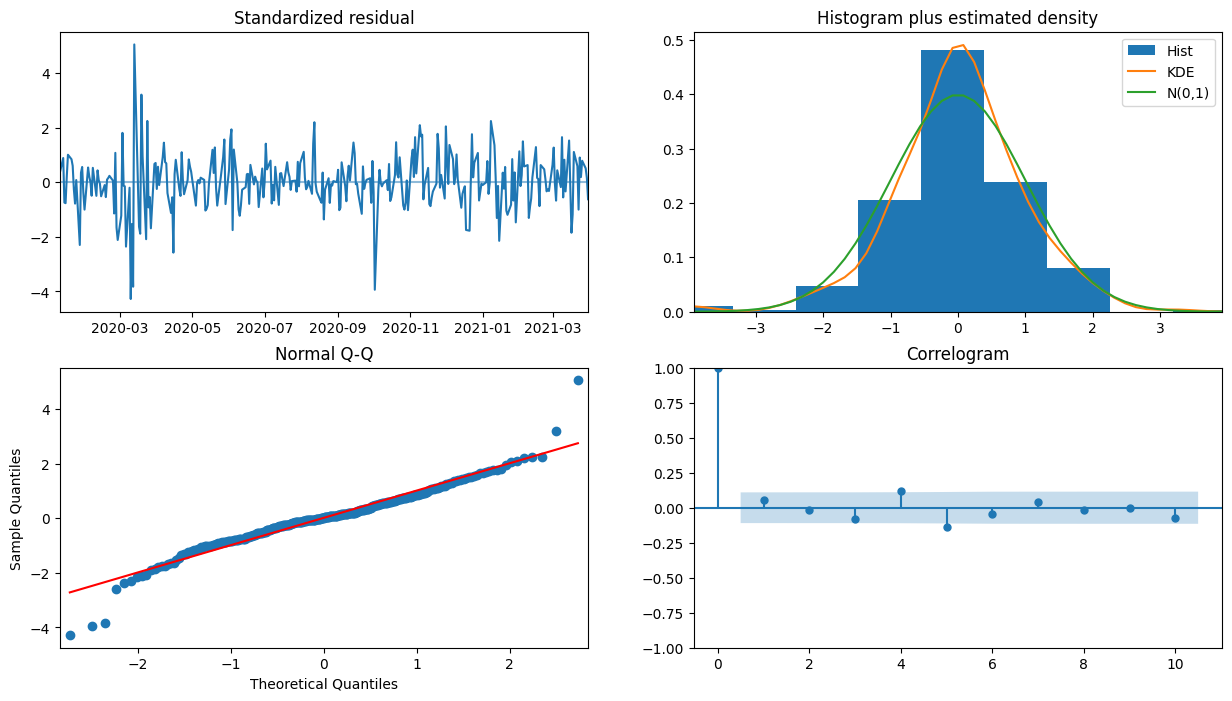

In [31]:
model_autoARIMA = auto_arima(ts_moving_avg_diff, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

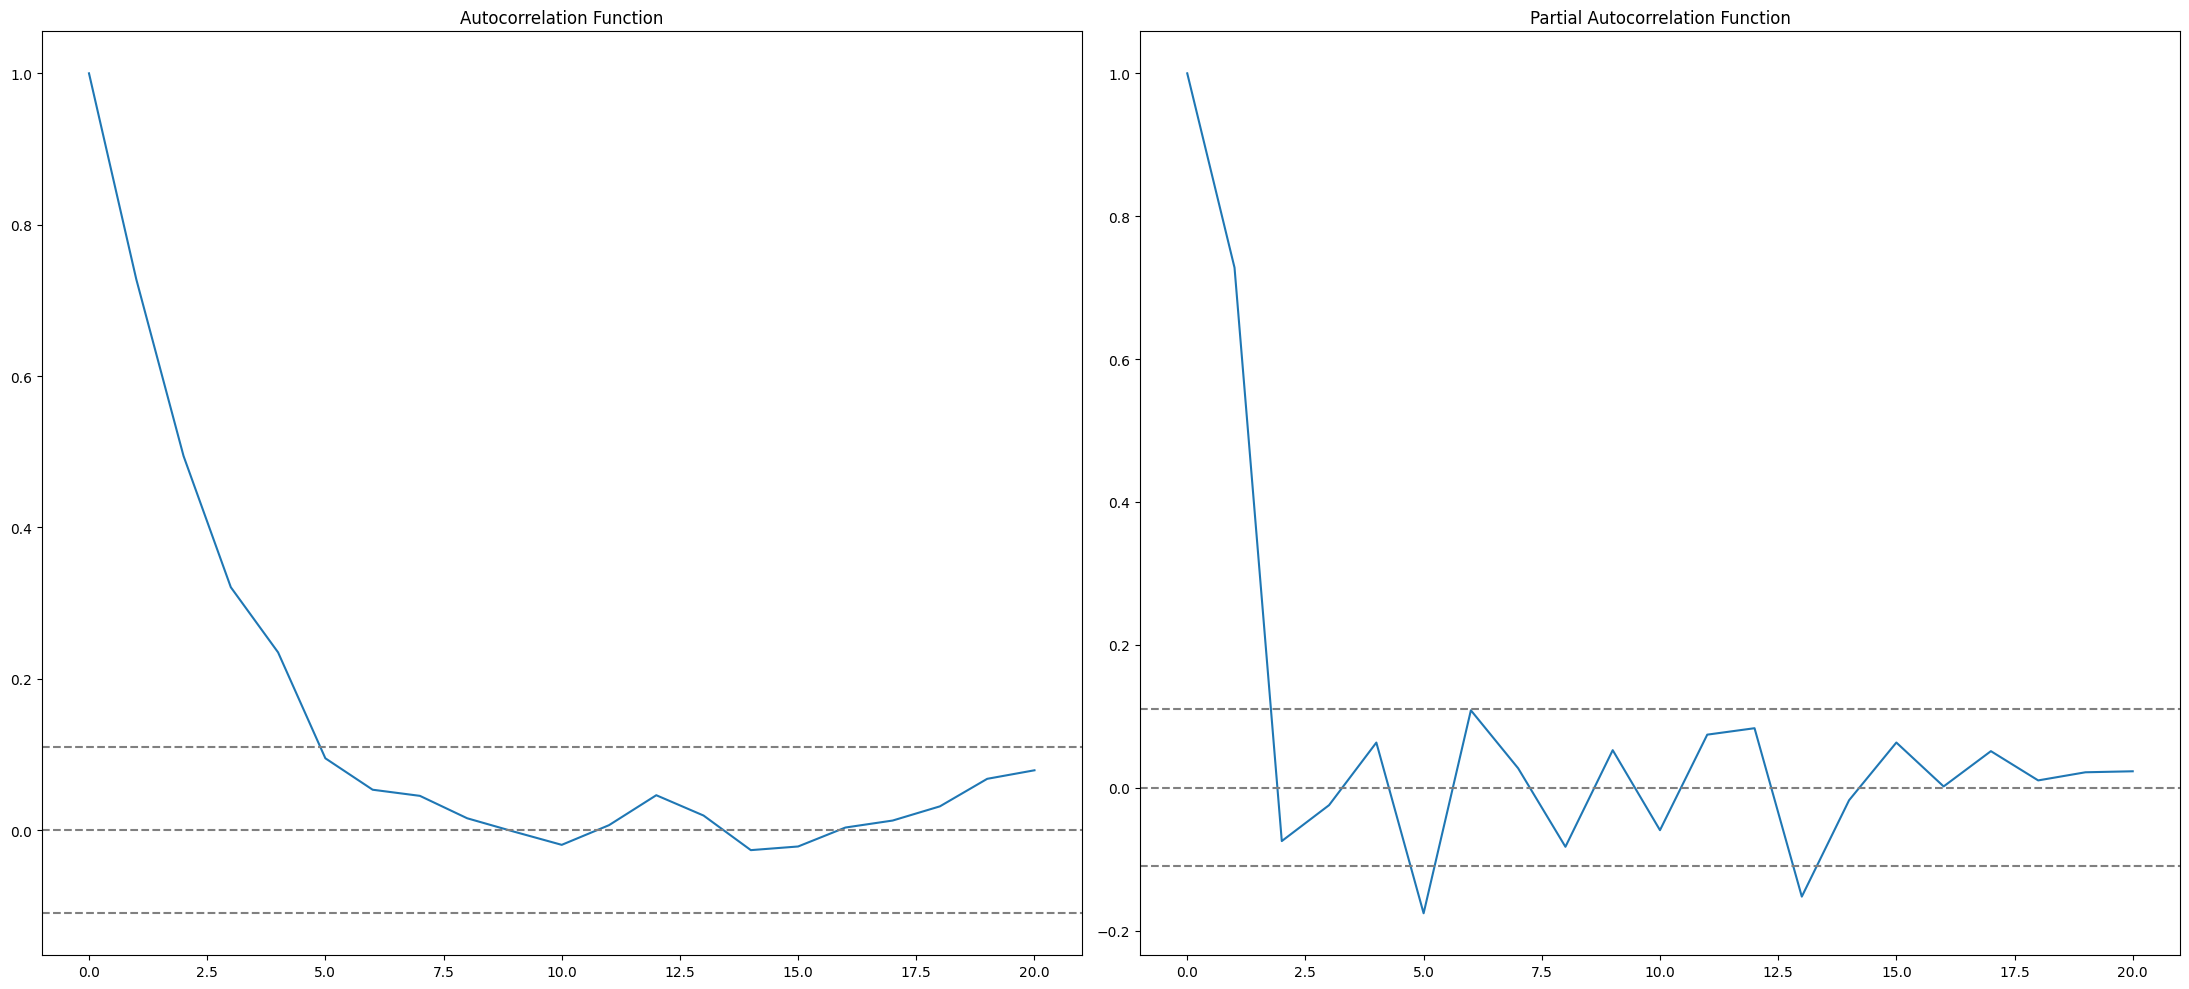

In [32]:
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts_moving_avg_diff, nlags=20)
lag_pacf = pacf(ts_moving_avg_diff, nlags=20, method='ols')
# ACF
plt.figure(figsize=(22,10))
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_moving_avg_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [33]:
#Modeling
# Build Model
model = ARIMA(price, order=(1,0,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  324
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -959.993
Date:                Sun, 15 Jan 2023   AIC                           1925.986
Time:                        21:48:12   BIC                           1937.328
Sample:                    01-03-2020   HQIC                          1930.513
                         - 03-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        249.6869     34.435      7.251      0.000     182.195     317.178
ar.L1          0.9906      0.007    135.712      0.000       0.976       1.005
sigma2        21.6645      1.041     20.802      0.0

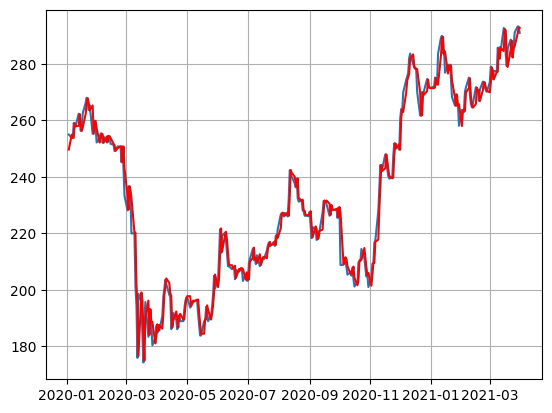

In [34]:
plt.grid(True)
plt.plot(price)
plt.plot(fitted.fittedvalues, color='red')

Comapring original  training data and predicted values we can see that model perform well.

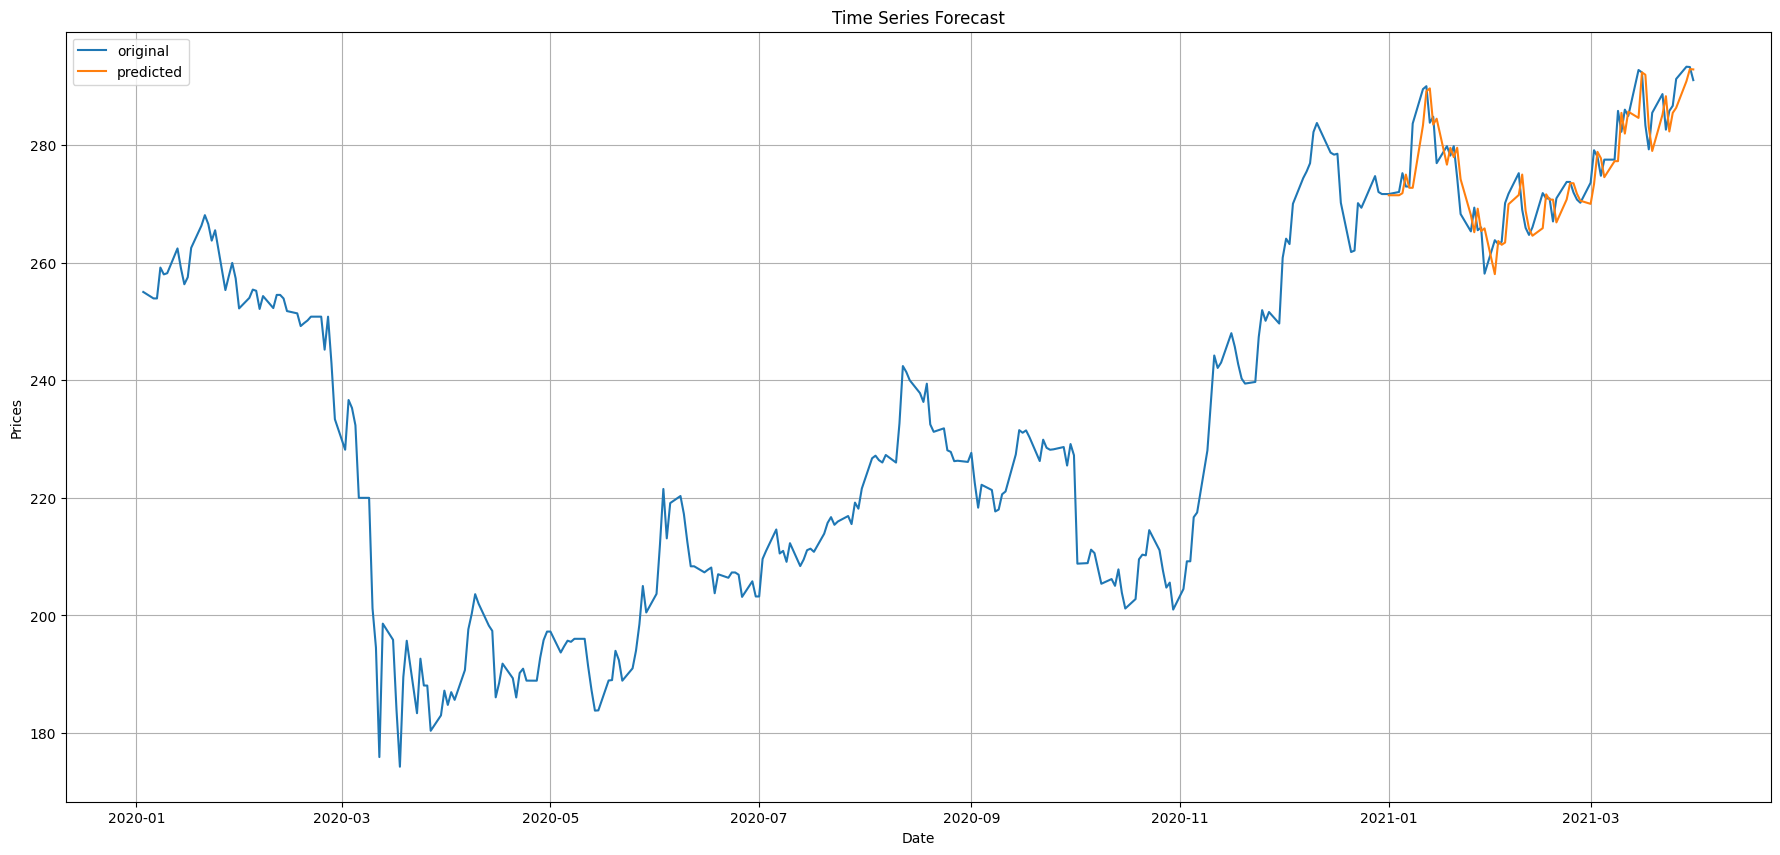

In [35]:
# predict
#test_daa
start_index = datetime(2021, 1, 1)
end_index = datetime(2021, 3, 31)
forecast = fitted.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(data_freq.index,data_freq.Price,label = "original")
plt.plot(forecast,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [36]:
#Check mean square error
from sklearn.metrics import mean_squared_error
error_arima = mean_squared_error(test_data, forecast)
print("error: " ,error_arima)

error:  17.46332888443762


## SARIMAX Model

In [37]:
autosarimax=auto_arima(ts_moving_avg_diff, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1777.259, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2018.789, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1780.610, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1864.215, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2017.531, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1782.408, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1782.739, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=1765.782, Time=0.32 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1780.578, Time=0.19 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=1766.474, Time=0.34 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=1766.851, Time=0.33 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=1773.839, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1779.722, Time=0.22 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(3,0,2)(0,0,0)[0]             : 

In [38]:
sarimax_model = SARIMAX(price, order = (3,0+1,2), seasonal_order= (3,0+1,2,5))
sarimax_result = sarimax_model.fit()

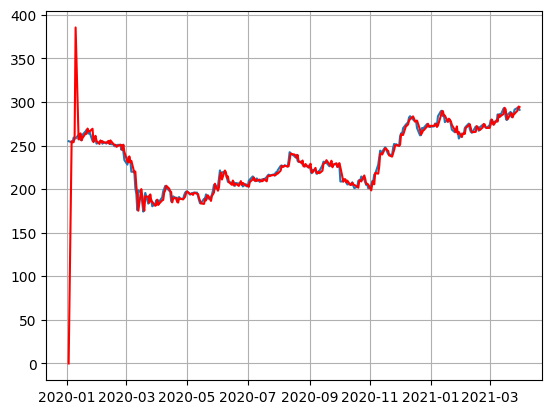

In [39]:
plt.grid(True)
plt.plot(price)
plt.plot(sarimax_result.fittedvalues, color='red')

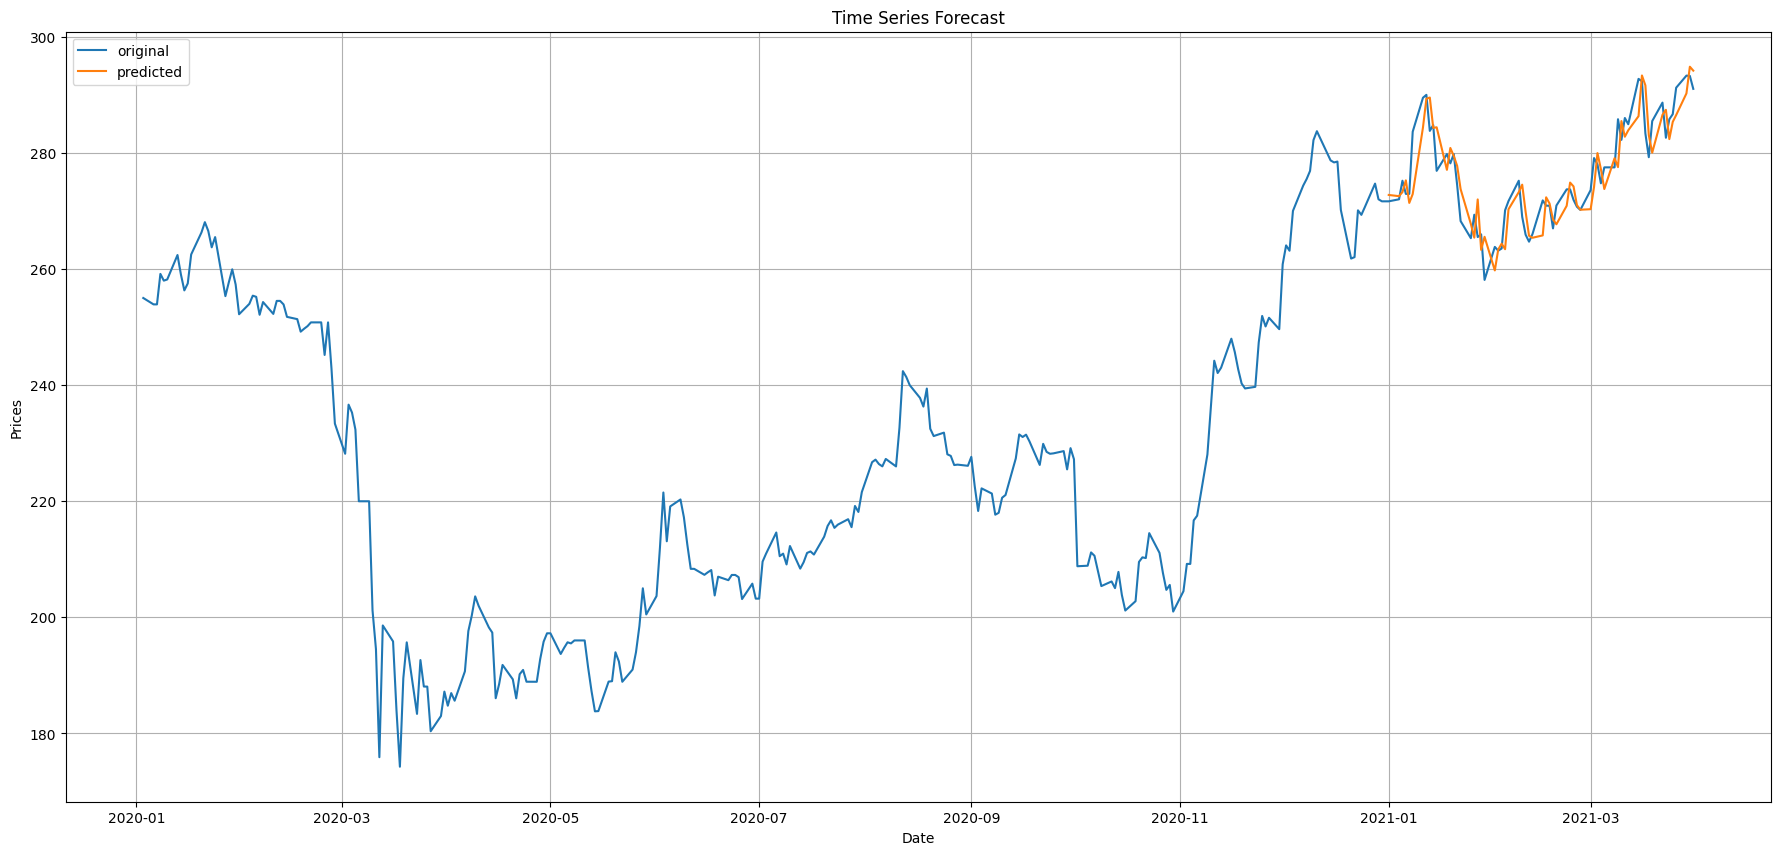

In [40]:
# predict
#test_daa
start_index = datetime(2021, 1, 1)
end_index = datetime(2021, 3, 31)
forecast_sarimax = sarimax_result.predict(start=start_index, end=end_index)

# visualization
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(data_freq.index,data_freq.Price,label = "original")
plt.plot(forecast_sarimax,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

In [41]:
#Check mean square error
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test_data, forecast_sarimax)
print("error: " ,error)

error:  15.623717564024759


## LSTM Model

### 1st Method
This method uses scalecast a library of time series models to train an lstm model.

In [42]:
f = Forecaster(y=price,current_dates=price.index)
f

Forecaster(
    DateStartActuals=2020-01-03T00:00:00.000000000
    DateEndActuals=2021-03-31T00:00:00.000000000
    Freq=B
    N_actuals=324
    ForecastLength=0
    Xvars=[]
    Differenced=0
    TestLength=1
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

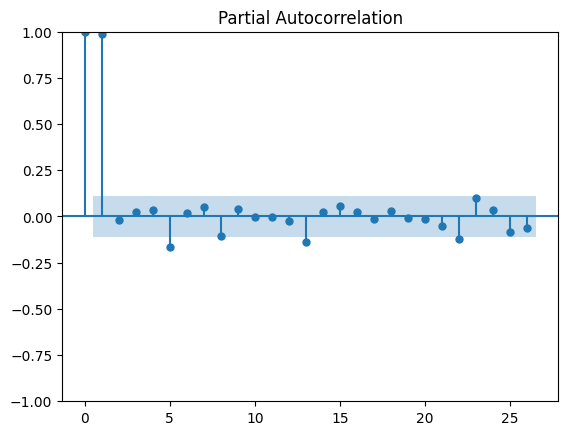

In [43]:
f.plot_pacf(lags=26)
plt.show()

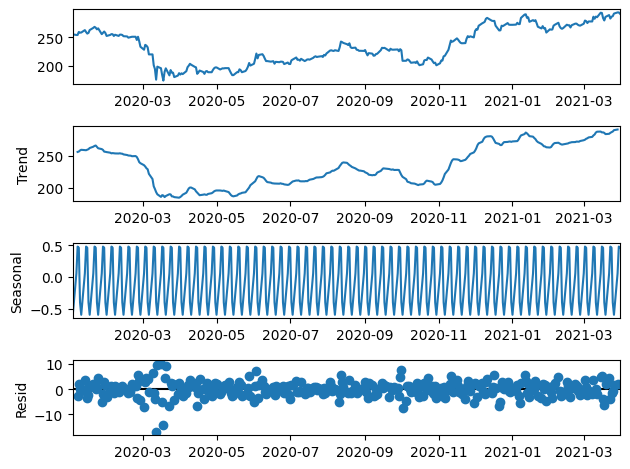

In [44]:
f.seasonal_decompose().plot()
plt.show()

In [45]:
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(f'Test stats: {stat}')
print(f'p-value: {pval}')

Test stats: -1.0418607602672183
p-value: 0.7376921461417357


In [46]:
f.set_test_length(64)       # 1. 12 observations to test the results
f.generate_future_dates(64) # 2. 12 future points to forecast
f.set_estimator('lstm') 

Epoch 1/50
186/186 [==============================] - 3s 7ms/step - loss: 0.1778
Epoch 2/50
186/186 [==============================] - 1s 7ms/step - loss: 0.1460
Epoch 3/50
186/186 [==============================] - 1s 7ms/step - loss: 0.1282
Epoch 4/50
186/186 [==============================] - 1s 7ms/step - loss: 0.1121
Epoch 5/50
186/186 [==============================] - 1s 6ms/step - loss: 0.1074
Epoch 6/50
186/186 [==============================] - 1s 6ms/step - loss: 0.1070
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.1023
Epoch 8/50
186/186 [==============================] - 1s 5ms/step - loss: 0.1015
Epoch 9/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0993
Epoch 10/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0996
Epoch 11/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0997
Epoch 12/50
186/186 [==============================] - 1s 4ms/step - loss: 0.1043
Epoch 13/50
186/186 [====

250/250 [==============================] - 2s 9ms/step - loss: 0.1137


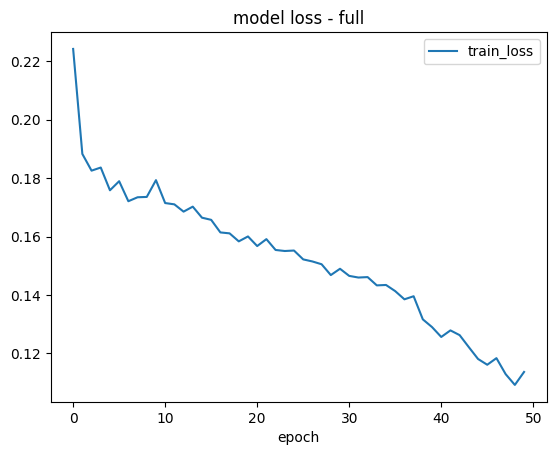

8/8 [==============================] - 0s 9ms/step


<AxesSubplot:xlabel='Date', ylabel='Values'>

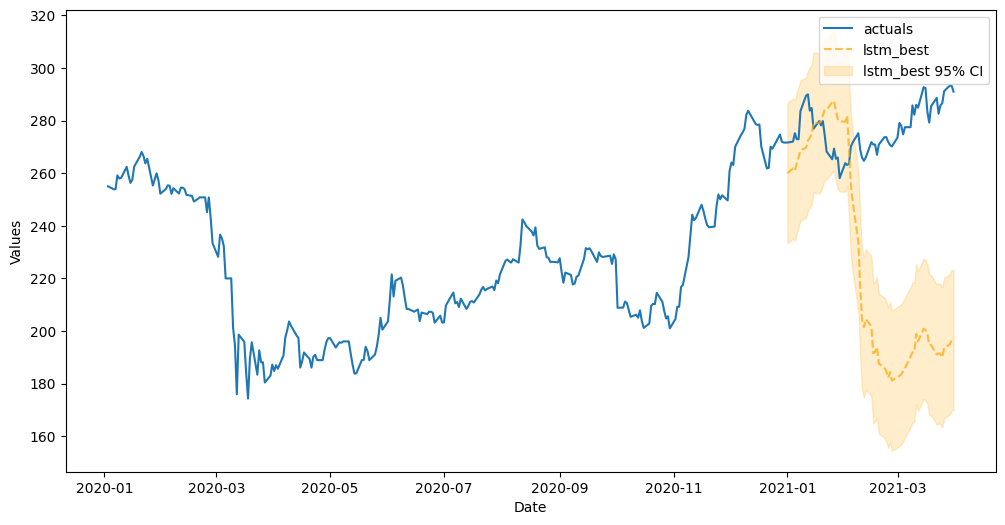

In [47]:
f.manual_forecast(call_me='lstm_best',
                  lags=10,
                  batch_size=1,
                  epochs=50,
                  shuffle=True,
                  activation='relu',
                  optimizer='Adam',
                  learning_rate=0.001,
                  lstm_layer_sizes=(100,)*2,
                  dropout=(0,)*2,
                  plot_loss=True)
f.plot_test_set(order_by='LevelTestSetMAPE',models='top_2',ci=True)

It can be seen from above graph that the result is not very good. Next method will be to build an LSTM model and train, test the data to see the resuls.

### 2nd Method

#### Train test split

In [131]:
#split data into train and training set
Seq_data = data.iloc[::-1]
train = Seq_data[0:(Seq_data.index.year==2020).sum()]
test = Seq_data[(Seq_data.index.year==2020).sum():]
train_sep = train[['Price']]
test_sep = test[['Price']]

In [66]:
test.shape

(61, 6)

#### Scaling the dataset

In [49]:
scaled = StandardScaler()
train_scaled = scaled.fit_transform(train_sep)
test_scaled = scaled.transform(test_sep)

In [75]:
input = 1
features = 1

final_train = TimeseriesGenerator(train_scaled, train_scaled, length=input, batch_size=1)
final_test = TimeseriesGenerator(test_scaled, test_scaled, length=input, batch_size=1)

In [76]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences = True, input_shape=(input, features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1, kernel_initializer = he_uniform()))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 100)            40800     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit(final_train,epochs=50)

Epoch 1/50
249/249 [==============================] - 3s 3ms/step - loss: 0.3873
Epoch 2/50
249/249 [==============================] - 1s 4ms/step - loss: 0.0413
Epoch 3/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0408
Epoch 4/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 5/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0423
Epoch 6/50
249/249 [==============================] - 1s 2ms/step - loss: 0.0379
Epoch 7/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0377
Epoch 8/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0406
Epoch 9/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0384
Epoch 10/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0372
Epoch 11/50
249/249 [==============================] - 1s 3ms/step - loss: 0.0380
Epoch 12/50
249/249 [==============================] - 1s 4ms/step - loss: 0.0378
Epoch 13/50
249/249 [====

In [78]:
model.evaluate(final_test)

60/60 [==============================] - 0s 1ms/step - loss: 0.0342


0.03421546891331673

60/60 [==============================] - 0s 1ms/step


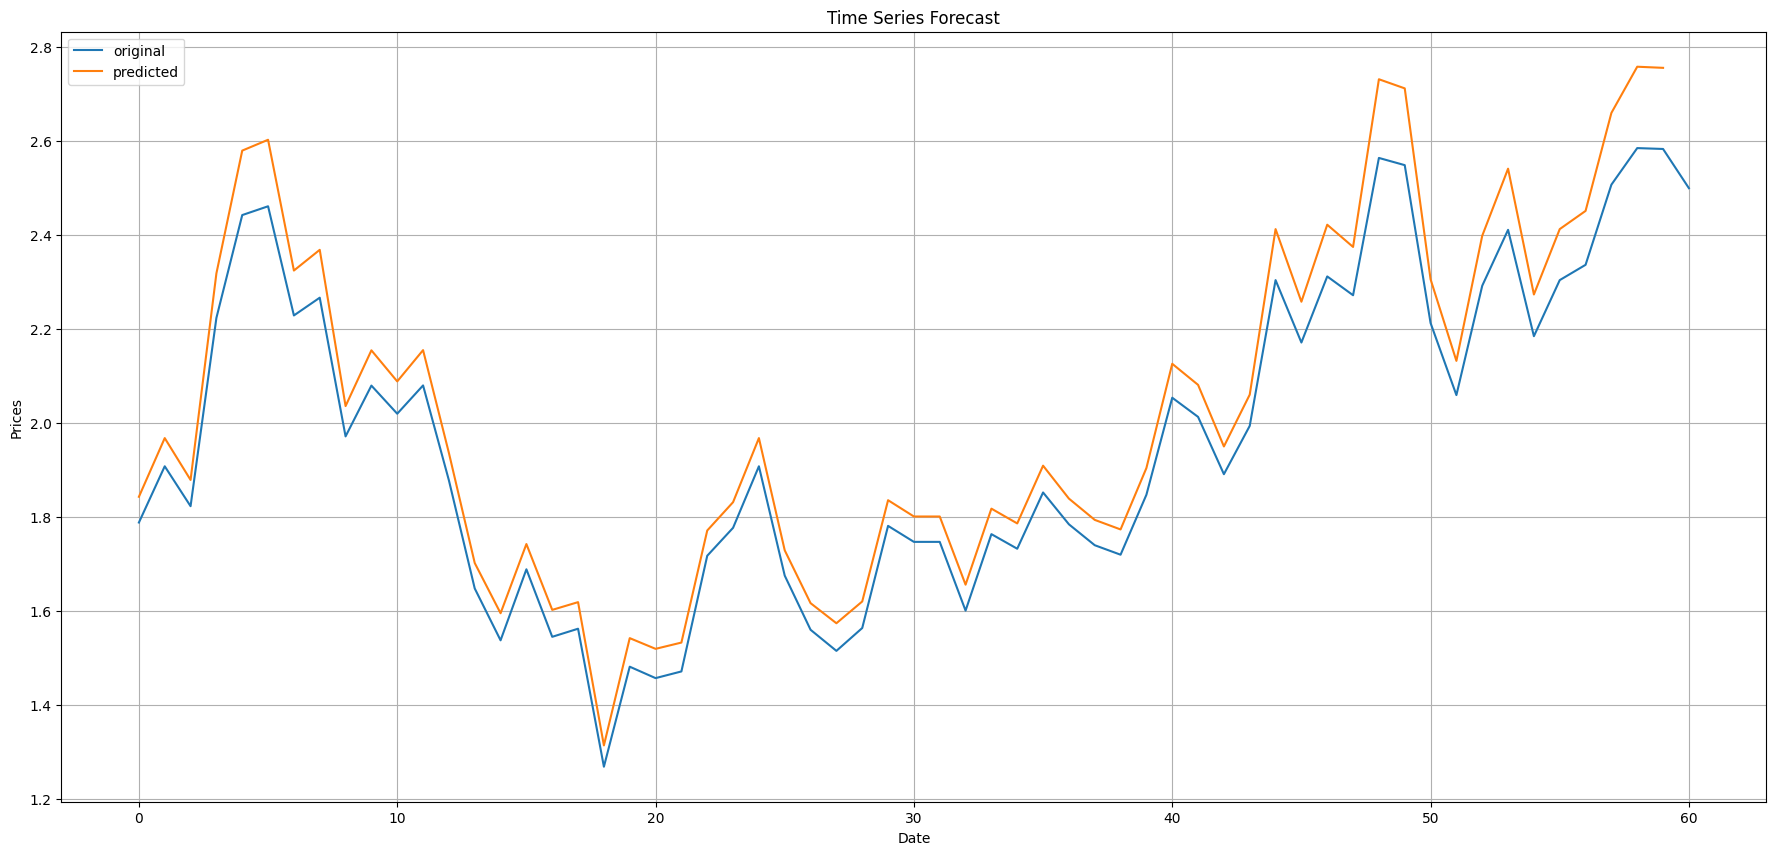

In [79]:
y_pred = model.predict(final_test)
plt.figure(figsize=(22,10))
plt.grid(True)
plt.plot(test_scaled,label = "original")
plt.plot(y_pred,label = "predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.show()

## Bollinger Bands

In [132]:
def bollinger_bands(period,data):
    data['sma'] = data['predicted'].rolling(period).mean()
    data['std'] = data['predicted'].rolling(period).std()
    data['upper'] = data['sma']+(data['std']*2)
    data['lower'] = data['sma']-(data['std']*2)
    return data
def get_signal(data):
    buy_signal = []
    sell_signal = []
    for i in range(len(data['predicted'])):
        if data['predicted'][i]>data['upper'][i]:
            buy_signal.append(np.nan)
            sell_signal.append(data['predicted'][i])
        elif data['predicted'][i]<data['lower'][i]:
            buy_signal.append(data['predicted'][i])
            sell_signal.append(np.nan)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
    return (buy_signal, sell_signal) 

### Analysis
Three models Arima,Sarimax, and LSTM were train and tested and LSTM has outperformed other Arima and Sarimax and will be chosen 
for bollinger bands evaluation.

In [133]:
test.drop(test.tail(1).index,inplace=True)

In [134]:
test['predicted'] = scaled.inverse_transform(y_pred).flatten()

In [141]:
bands_data=bollinger_bands(,test)

In [143]:
bands_data['buy'] = get_signal(bands_data)[0]
bands_data['sell'] = get_signal(bands_data)[1]

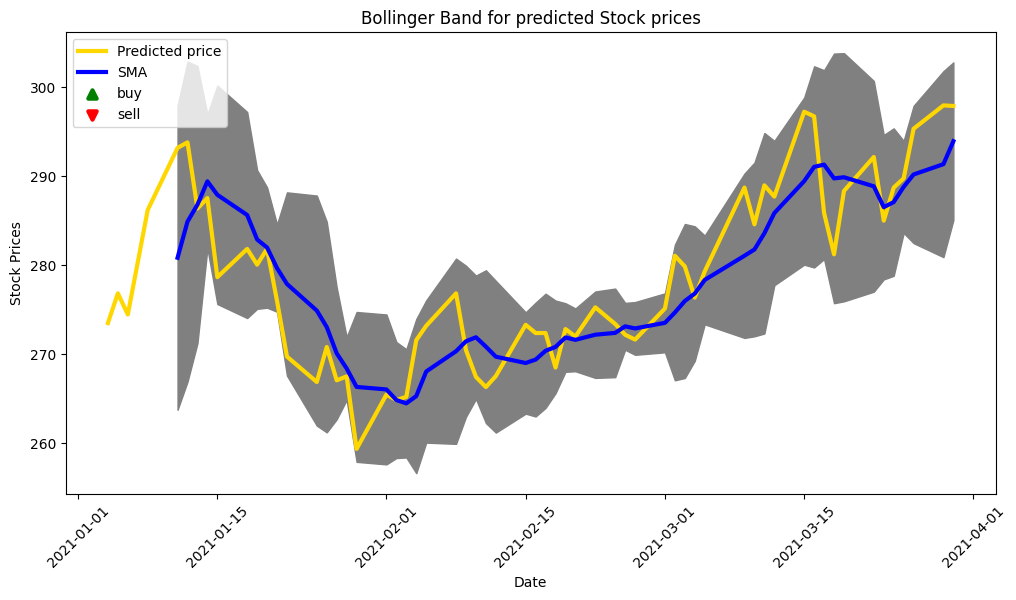

In [137]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
x_axis = bands_data.index
ax.fill_between(x_axis, bands_data['upper'],bands_data['lower'],color='grey')
ax.plot(x_axis, bands_data['predicted'],color = 'gold',lw=3,label='Predicted price')
ax.plot(x_axis, bands_data['sma'],color = 'blue',lw=3,label='SMA')
ax.scatter(x_axis, bands_data['buy'],color='green',lw=3,label='buy',marker='^')
ax.scatter(x_axis, bands_data['sell'],color='red',lw=3,label='sell',marker='v')
ax.set_title('Bollinger Band for predicted Stock prices')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Prices')
plt.xticks(rotation = 45)
ax.legend()
plt.show()

## Conclusion
Using Bollinger Bands on predicted prices for 2021 data do not yield any buy or cell signal, this can only be due to the fact that only one year worth of data is available for training, However using more data could imporve the performance.